# Scale Invariant Feature Detector
by Robinson Garcia

sources:


Ref: https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
Ref: https://www.dropbox.com/sh/26xgy96py8itk14/AABhgCbYzraeSMkDpjY92kFVa/Lecture%20slides?dl=0&preview=2017f.Week10.Topic15.lecture.sift.pdf&subfolder_nav_tracking=1
Ref: https://cs.nyu.edu/~fergus/teaching/vision_2012/3_Corners_Blobs_Descriptors.pdf
Ref: https://arxiv.org/pdf/1603.09114.pdf

In [1]:
'''python libraries'''
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from numba import jit

%load_ext autoreload
%load_ext cython
%autoreload 2
%matplotlib inline

In [2]:
use_cython=True

# Feature extractor:

## Image processing / filtering / gradients

In [3]:
def pyGaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append(math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))

    return np.array(G).reshape(w,h)/np.sum(np.array(G))

In [4]:
%%cython 
import numpy as np
import math
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef GaussianFilter(int w,int h,float sigma):
    cdef int m = int((w-1)/2)
    cdef int n = int((h-1)/2)
    cdef np.ndarray[np.float64_t,ndim=2] G = np.empty((h,w))
    cdef double Gsum = 0.0
    cdef int i,j
    for i in range(w):
        for j in range(h):
            G[j,i] = math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2))
            Gsum += G[j,i]

    return G/Gsum

In [5]:
def Expand_stack(im_stack,size):
    N,H,W = im_stack.shape
    _,h,w = size
    factor = int(H/h)
    base=np.zeros((N,h,w))
    i = np.arange(H)*factor
    j = np.arange(W)*factor
    j = np.repeat(j[np.newaxis,:],H,axis=0)
    i = np.repeat(i[:,np.newaxis],W,axis=1)
    print(i.shape,j.shape)
    print(base.shape)
    base[:,i,j] = im_stack
    return base


In [6]:
%%cython 
'''reference from cs231n'''
import numpy as np
cimport numpy as np
cimport cython


ctypedef fused DTYPE_t:
    np.float32_t
    np.float64_t

cpdef im2col_cython(np.ndarray[DTYPE_t, ndim=4] x, int field_height,
                  int field_width, int padding, int stride):
    cdef int N = x.shape[0]
    cdef int C = x.shape[1]
    cdef int H = x.shape[2]
    cdef int W = x.shape[3]

    cdef int HH = int((H + 2 * padding - field_height) / stride + 1)
    cdef int WW = int((W + 2 * padding - field_width) / stride + 1)

    cdef int p = padding
    cdef np.ndarray[DTYPE_t, ndim=4] x_padded = np.pad(x,
            ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    cdef np.ndarray[DTYPE_t, ndim=2] cols = np.zeros(
            (C * field_height * field_width, N * HH * WW),
            dtype=x.dtype)

    # Moving the inner loop to a C function with no bounds checking works, but does
    # not seem to help performance in any measurable way.

    im2col_cython_inner(cols, x_padded, N, C, H, W, HH, WW,
                        field_height, field_width, padding, stride)
    return cols

@cython.boundscheck(False)
cdef int im2col_cython_inner(np.ndarray[DTYPE_t, ndim=2] cols,
                             np.ndarray[DTYPE_t, ndim=4] x_padded,
                             int N, int C, int H, int W, int HH, int WW,
                             int field_height, int field_width, int padding, int stride) except? -1:
    cdef int c, ii, jj, row, yy, xx, i, col

    for c in range(C):
        for yy in range(HH):
            for xx in range(WW):
                for ii in range(field_height):
                    for jj in range(field_width):
                        row = c * field_width * field_height + ii * field_height + jj
                        for i in range(N):
                            col = yy * WW * N + xx * N + i
                            cols[row, col] = x_padded[i, c, stride * yy + ii, stride * xx + jj]

In [7]:
def conv_octave_cython(im,g,stride=1,C=3):
    im = im[:,np.newaxis,:,:]

    N,_,H,W = im.shape
    _,h,w = g.shape

    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)

    ii = np.zeros((N,H*W))
    for t,i in enumerate(im):
        img = i[np.newaxis,:,:]
        cols = im2col_cython(img, h, w, h_pad,stride)
        gg = g[t].flatten()
        ii[t]=np.matmul(cols.T,gg)
    return ii.reshape(-1,H,W)

In [8]:
def filter_stack(sig0,s,h,w):
    k = 2**(1/s)
    sigma = np.power(k,np.arange(s+1))*sig0
    g = []
    for std in sigma:
        g.append(GaussianFilter(h,w,std))
    return np.stack(g),sigma
            

## Pyramid of DOG images:
$$D(x,y,\rho) = I(x,y)*(G(x,y,k\rho) - G(x,y,\rho))$$
for $$\rho=\sigma.k\sigma,k^2\sigma,...,k^{s-1}\sigma$$

In [9]:
def scale_zero2one(M):
    
    min_ = M.min()
    max_ = M.max()
    M = (M-min_)/(max_-min_)

    return M

In [10]:
def octave(im_stack,factor,sig0=1.6,s=5,h=3,w=3):
    g,sigma = filter_stack(sig0,s,h,w)
    #s1 = np.array([[0,1,0],[0,0,0],[0,-1,0]])
    s1 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T
    s2 = np.repeat(s1.T[np.newaxis,:,:],s+1,axis=0)
    s1 = np.repeat(s1[np.newaxis,:,:],s+1,axis=0)
    
    L = conv_octave_cython(Reduce_stack(im_stack,factor),g)
    L = scale_zero2one(L)
    
    D = L[1:s+1] - L[0:s]
    
    L_gradx = conv_octave_cython(L,s1)
    L_grady = conv_octave_cython(L,s2)

    return D,L,sigma,(L_gradx,L_grady)

In [11]:
%%cython 

import numpy as np
cimport numpy as np
cimport cython


@cython.boundscheck(False)
@cython.wraparound(False)
cdef GaussianFilter(int w,int h,float sigma):
    cdef int m = int((w-1)/2)
    cdef int n = int((h-1)/2)
    cdef np.ndarray[np.float64_t,ndim=2] G = np.empty((h,w))
    cdef float Gsum = 0.0
    cdef int i,j
    cdef float E = 2.718281828459045
    for i in range(w):
        for j in range(h):
            G[j,i] = E**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2))
            Gsum += G[j,i]

    return G/Gsum

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef histogram(np.ndarray[np.float64_t,ndim=2] x,
np.ndarray[np.float64_t,ndim=2] w,
np.ndarray[np.float64_t,ndim=1] bins,
np.ndarray[np.float64_t,ndim=2] xk,int n):

    cdef int nn = x.shape[0]
    
    cdef np.ndarray[np.float64_t,ndim=2] hist = np.zeros((nn,n+1))

    cdef np.ndarray[np.float64_t,ndim=2] G = np.zeros((nn,9))

    cdef int i,ii,j
    
    for i in range(nn):
        G[i,:] = GaussianFilter(3,3,1.5*xk[i,3]).flatten()


    for ii in range(nn):
        for i in x[ii,:]:
            for j in range(n+1):
                if i < bins[j]:
                    hist[ii,j]+=w[ii,j]*G[ii,i]
                    break

    return hist

In [12]:
def set_rho(Lgrad,xk,h,w):
    
    Lgradx,Lgrady = Lgrad
    Lmod =np.sqrt(Lgradx**2+Lgrady**2)
    Lrho = np.arctan2(Lgrady,Lgradx)
    Lrho[Lrho<0]+=2*math.pi
    Lmod = get_patches3(Lmod,xk,h,w)
    Lrho = get_patches3(Lrho,xk,h,w)
    bins = np.arange(0,2*math.pi+math.pi/36,2*math.pi/36)
    hist = histogram(Lmod.reshape((Lmod.shape[0],-1)),
                                   Lrho.reshape((Lrho.shape[0],-1)),
                                   bins,xk,8)
    
    mod = np.sum(hist**2,axis=1)[:,np.newaxis]
    hist=np.divide(hist,mod,out=np.zeros_like(hist),where=mod!=0)
    idx = np.argmax(hist,axis=1)
    rho = bins[idx]
                       
    return np.vstack((xk.T,rho)).T

    
    

In [13]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef get_patches3(np.ndarray[np.float64_t,ndim=3] D, np.ndarray[np.float_t,ndim=2] xk, int h=3, int w=3, stride=1):

    cdef int N = D.shape[0]
    cdef int H = D.shape[1]
    cdef int W = D.shape[2]
    cdef f


    cdef int h_pad = int((H * (stride - 1) - stride + h) / 2)
    cdef int w_pad = int((W * (stride - 1) - stride + w) / 2)

    cdef int h_ = int((h - 1) / 2)
    cdef int w_ = int((w - 1) / 2)
    cdef int k,i,j
    cdef int n = xk.shape[0]

    cdef np.ndarray[np.float64_t,ndim=3] patches = np.zeros((n,h,w))
    cdef np.ndarray[np.float64_t,ndim=3] D_padded = np.pad(D, ((0, 0), (h_pad, h_pad), (w_pad, w_pad)), 'constant')

    for f in range(n):
        i, j,k,_ = xk[f].astype(int)

        i += h_pad
        j += w_pad
        patches[f,:,:] = D_padded[k, i - h_:i + h_ + 1, j - w_:j + w_ + 1]


    return patches


## Detecting DOG extrema

Find all pixels that correspond to extrema of $D(x,y,\rho)$. For each $(x,y,\rho)$, check wether $D(x,y,\rho)$ is greater than (or smaller than) all of its neighbours in current scale and adjacent scales above & below.

In [14]:
def get_im2col_indices_conv2d_max(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

def conv2d_max(f,g,k=1,**kwargs):
    #f = f[:,np.newaxis,:,:]
    #f = np.repeat(f,3,axis=1)

    N,H,W=f.shape

    n = np.tile(np.arange(3),N-2) + np.repeat(np.arange(N-2),3)
    f = f[n,:,:].reshape((N-2,3,H,W))

    N,C,H,W = f.shape
    h,w = g

    x_pad = int(0.5*((W-1)*1-W+w))
    y_pad = int(0.5*((H-1)*1-H+w))

    f_pad = np.pad(f,((0,0),(0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='maximum')

    k,i,j = get_im2col_indices_conv2d_max((N,C,H,W), h, w, p_x=x_pad,p_y=y_pad, stride=1)

    cols = f_pad[:,k,i,j]

    xc = int((h*w-1)/2)
    cols = np.delete(cols,(xc,xc+h*w,xc+2*h*w),1)

    cond = ((f[:,1,:,:].flatten() >
             np.max(cols,axis=1).flatten())|(f[:,1,:,:].flatten() <
                                   np.min(cols,axis=1).flatten()))

    return np.moveaxis(cond.reshape(N,H,W),0,2)

## Refining location of Extrema
2nd order taylor expansion of D at $(x,y,\rho)$:
$$D\left(\Delta\vec{x}^{\,}\right) = D(\vec{x}^{\,}) +\left(\frac{\partial D}{\partial \vec{x}^{\,}}\right)^T\Delta\vec{x}^{\,} + \frac{1}{2}\left(\Delta\vec{x}^{\,}\right)^T\frac{\partial^2 D}{\partial \vec{x}^{\,2}}\left(\Delta\vec{x}^{\,}\right)$$
Gradient wrt $\Delta\vec{x}^{\,}$:
$$\frac{\partial D}{\partial \Delta\vec{x}^{\,} } = \left(\frac{\partial D}{\partial \vec{x}^{\,}}\right) + \frac{\partial^2 D}{\partial \vec{x}^{\,2}}\left(\Delta\vec{x}^{\,}\right)$$
Minimum occurs when $\frac{\partial D}{\partial \Delta\vec{x}^{\,} }=0$
$$\Delta\vec{x}^{\,}  = - \left(\frac{\partial^2 D}{\partial \vec{x}^{\,2}}^{-1}\right)\left(\frac{\partial D}{\partial \vec{x}^{\,}}\right)$$

All gradients estimated using finite differences


## Compute new locations and prune insignificant extrema:

Find the Hessian for each key point and prune if $\frac{Tr^2(H)}{Det(H)}>(1.1)^2$.

Look for Harris Corner detector to understand this

## Keypoint orientation assignment
 Contribution to the bin is: $$\left|\nabla I(x,y)\right|G_{1.5\rho_i}(d)$$

In [15]:
def build_sig(xk,sigma):
    sig = np.zeros(xk.shape[0])
    k=0
    for i in xk:
        sig[k] = sigma[i[2]]
        k+=1
    return np.vstack((xk.T,sig)).T
    

In [16]:
def HOG(L_grad,xk,h=9,w=9):
    Lx,Ly = L_grad
    Lmod = np.sqrt(Lx**2+Ly**2)
    rho = np.arctan2(Ly,Lx)
    rho[rho<0]+=2*math.pi
    Lmod_patches = get_patches3(Lmod,xk,h,w)
    rho_patches = get_patches3(rho,xk,h,w)
    return Lmod_patches,rho_patches

In [17]:
def harris2(D,xk,edge_th):
    
    #gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    gy = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    gx = gy.T
    gx = np.repeat(gx[np.newaxis,:,:],D.shape[0],axis=0)
    gy = np.repeat(gy[np.newaxis,:,:],D.shape[0],axis=0)

    D2grad_x = conv_octave_cython(D,gx)
    D2grad_y = conv_octave_cython(D,gy)

    Dxx = np.sum(get_patches3(D2grad_x,xk),axis=(1,2))
    Dyy = np.sum(get_patches3(D2grad_y,xk),axis=(1,2))

    H = np.array([[Dxx**2,Dxx*Dyy],[Dxx*Dyy,Dyy**2]])

    tr = np.trace(H)**2
    det = np.linalg.det(np.moveaxis(H,2,0))

    #R = det - 0.04*tr
    return np.divide(tr,det,out=np.zeros_like(tr),where=det!=0)<((edge_th+1)/10)**2

In [18]:
def get_deriv(pyr,kp):
    pyr = np.moveaxis(pyr,0,2)

    z = kp[:,2].astype(int)
    y = kp[:,1].astype(int)+1
    x = kp[:,0].astype(int)+1


    pyr = np.pad(pyr,((1,1),(1,1),(0,0)),'maximum')

    Ix = pyr[x+1,y,z] - pyr[x-1,y,z]
    Iy = pyr[x,y+1,z] - pyr[x,y-1,z]
    Is = pyr[x,y,z+1] - pyr[x,y,z-1]
    Ixy = pyr[x+1,y+1,z] - pyr[x-1,y-1,z]

    #H = np.array([[Ix,Ixy],[Ixy,Iy]])

    Ixx = pyr[x+1,y,z] - 2*pyr[x,y,z] + pyr[x-1,y,z]
    Iyy = pyr[x,y+1,z] - 2*pyr[x,y,z] + pyr[x,y-1,z]
    Iss = pyr[x,y,z+1] - 2*pyr[x,y,z] + pyr[x,y,z-1]
    Ixxyy = pyr[x+1,y+1,z] - 2*pyr[x,y,z] + pyr[x-1,y-1,z]
    Ixxss = pyr[x+1,y,z+1] - 2*pyr[x,y,z] + pyr[x-1,y,z-1]
    Iyyss = pyr[x,y+1,z+1] - 2*pyr[x,y,z] + pyr[x,y-1,z-1]

    H = np.array([[Ixx,Ixxyy,Ixxss],[Ixxyy,Iyy,Iyyss],[Ixxss,Iyyss,Iss]])
    J = np.array([[Ix**2,Ix*Iy],[Ix*Iy,Iy**2]])
    dx = np.array([Ix,Iy,Is])
    return H,dx,J

In [19]:
def refine_location_prune(im,D,kp,peak_th=0.03,edge_th=10,debug=False):
    D = D**2
    #D = (D-D.min())/(D.max()-D.min())
    
    H,dx,J = get_deriv(D,kp)

    U,S,V = np.linalg.svd(np.moveaxis(H,2,0))
    S = S[:,:,np.newaxis]*np.diag(np.ones(3))
    A = np.linalg.inv(S)
    H_inv = np.matmul(-np.matmul(A,S),V)
    deltas = np.squeeze(np.matmul(H_inv,np.moveaxis(dx,1,0)[:,:,np.newaxis]))
    #deltas=np.round(deltas)

    xk=kp
    D[xk[:,2].astype(int),xk[:,0].astype(int),xk[:,1].astype(int)]+=0.5*np.sum(dx.T*deltas,axis=1)

    Ds = D[xk[:,2].astype(int),xk[:,0].astype(int),xk[:,1].astype(int)]
    Ds = (Ds-Ds.min())/(Ds.max()-Ds.min())
    if debug==True: print('Maximum contrast: {}'.format(Ds.max()))
    if debug==True: print('Minimum contrast: {}'.format(Ds.min()))
    if debug==True: print('Average contrast: {}'.format(Ds.mean()))
    cond1 = Ds > peak_th
    if debug==True: print("Number of kps removed after th: {}".format(np.sum(~cond1)))
    #if kp.shape[1]!=0:
    cond2 = harris2(D,kp,edge_th)
    if debug==True: print("Number of kps removed edge extraction: {}".format(np.sum(~cond2)))

    keep = ((cond2) & (cond1))
    return (deltas,keep)

# Descriptor

In [20]:
%%cython
import numpy as np
import math
cimport numpy as np
cimport cython

'''
xks:
    0 - x
    1 - y
    2 - scale index
    3 - scale/sigma
    4 - grad orientations
'''

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef GaussianFilter(int w,int h,float sigma):
    cdef int m = int((w-1)/2)
    cdef int n = int((h-1)/2)
    cdef np.ndarray[np.float64_t,ndim=2] G = np.empty((h,w))
    cdef double Gsum = 0.0
    cdef int i,j
    for i in range(w):
        for j in range(h):
            G[j,i] = math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2))
            Gsum += G[j,i]

    return G/Gsum

@cython.boundscheck(False)
@cython.wraparound(False)
cdef get_descriptors_idx(np.ndarray[np.float64_t,ndim=2] xk,int block_size=16,int cell_size=4,int nBins=8):


    cdef int nKps = xk.shape[0] #number of keypoints

    cdef int half_block = int(block_size/2)

    cdef int nCells = int((block_size/cell_size)**2)

    cdef int half_cell = int(cell_size/2)

    cdef np.ndarray[np.int_t,ndim=4] block_s = np.zeros((nKps,nCells,cell_size+1,cell_size+1)).astype(np.int)
    cdef np.ndarray[np.int_t,ndim=4] block_i = np.zeros((nKps,nCells,cell_size+1,cell_size+1)).astype(np.int)
    cdef np.ndarray[np.int_t,ndim=4] block_j = np.zeros((nKps,nCells,cell_size+1,cell_size+1)).astype(np.int)

    cdef np.ndarray[np.int_t,ndim=1] HH = np.arange(-half_block,half_block,cell_size)
    cdef np.ndarray[np.int_t,ndim=1] WW = np.arange(-half_block,half_block,cell_size)

    cdef np.ndarray[np.int_t,ndim=1] hh = np.arange(0,cell_size+1)
    cdef np.ndarray[np.int_t,ndim=1] ww = np.arange(0,cell_size+1)

    cdef int t0,scale_idx,iii,jjj,t1,ii,jj,t2,i,t3,j

    cdef double scale_sigma,rho

    t0=0
    for kp in xk:
        scale_idx = int(kp[2])
        scale_sigma = kp[3]
        rho = kp[4]
        iii,jjj = kp[:2].astype(int)
        t1=0
        for ii in HH:
            for jj in WW:
                t2 = 0
                for i in hh:
                    t3 = 0
                    for j in ww:

                        block_s[t0,t1,t2,t3] = scale_idx
                        block_i[t0,t1,t2,t3] = half_block+iii+i+ii
                        block_j[t0,t1,t2,t3] = half_block+jjj+j+jj

                        t3+=1
                    t2+=1

                t1+=1

        t0+=1

    return block_s,block_i,block_j



@cython.boundscheck(False)
@cython.wraparound(False)
cdef get_hist(np.ndarray[np.int_t,ndim=4] idx,np.ndarray[np.float64_t,ndim=3] Dmod,
np.ndarray[np.float64_t,ndim=2] xk,int block_size=16,int cell_size=4,int nBins=8):

    cdef np.ndarray[np.float64_t,ndim=1] sigmas = np.unique(xk[:,3])

    cdef int nSigmas = sigmas.shape[0]

    cdef np.ndarray[np.float64_t,ndim=2] histogram = np.zeros((idx.shape[0],nBins*idx.shape[1]))

    weights = {}
    for sig in sigmas:
        weights[sig] = GaussianFilter(block_size,block_size,sig)

    cdef int nKps = xk.shape[0] #number of keypoints

    cdef int half_block = int(block_size/2)

    cdef int nCells = int((block_size/cell_size)**2)

    cdef int half_cell = int(cell_size/2)

    cdef np.ndarray[np.float64_t,ndim=3] Dmod_padded = np.pad(Dmod,((0,0),(half_block,half_block),(half_block,half_block)),'linear_ramp')

    cdef np.ndarray[np.int_t,ndim=1] HH = np.arange(-half_block,half_block,cell_size)
    cdef np.ndarray[np.int_t,ndim=1] WW = np.arange(-half_block,half_block,cell_size)

    cdef np.ndarray[np.int_t,ndim=1] hh = np.arange(0,cell_size+1)
    cdef np.ndarray[np.int_t,ndim=1] ww = np.arange(0,cell_size+1)

    cdef int t0,scale_idx,iii,jjj,t1,ii,t2,i,jj,t3,j
    cdef double scale_sigma,rho

    cdef float mod

    t0=0
    for kp in xk:
        scale_idx = int(kp[2])
        scale_sigma = kp[3]
        rho = kp[4]
        iii,jjj = kp[:2].astype(int)
        t1=0
        for ii in HH:
            for jj in WW:
                t2 = 0
                for i in hh:
                    t3 = 0
                    for j in ww:
                        mod = Dmod_padded[scale_idx,half_block+iii+i+ii,half_block+jjj+j+jj]
                        histogram[t0,idx[t0,t1,t2,t3]+t1*8]+= mod*weights[scale_sigma][ii+i,jj+j]
                        t3+=1
                    t2+=1
                t1+=1
        t0+=1

    return histogram


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef build_fk(np.ndarray[np.float64_t,ndim=3] Dmod,np.ndarray[np.float64_t,ndim=3] Drho,
np.ndarray[np.float64_t,ndim=2] xk,int block_size=16,int cell_size=4,int nBins=8):

    cdef np.ndarray[np.int_t,ndim=4] s,i,j

    s,i,j = get_descriptors_idx(xk,block_size,cell_size,nBins=nBins)

    cdef int half_block = int(block_size/2)

    cdef np.ndarray[np.float64_t,ndim=3] Dmod_padded = np.pad(Dmod,((0,0),(half_block,half_block),(half_block,half_block)),'linear_ramp')
    cdef np.ndarray[np.float64_t,ndim=3] Drho_padded = np.pad(Drho,((0,0),(half_block,half_block),(half_block,half_block)),'linear_ramp')


    cdef np.ndarray[np.float64_t,ndim=4] Dmod_patches = Dmod_padded[s,i,j]
    cdef np.ndarray[np.float64_t,ndim=4] Drho_patches = Drho_padded[s,i,j]

    cdef np.ndarray[np.float64_t,ndim=4] relRho = Drho_patches - xk[:,3][:,np.newaxis,np.newaxis,np.newaxis]

    relRho[relRho<0]+=2*math.pi

    cdef np.ndarray[np.float64_t,ndim=1] bins = np.linspace(math.pi/nBins,2*math.pi,nBins)

    cdef np.ndarray[np.int_t,ndim=4] idx = np.searchsorted(bins, relRho,'right')

    cdef np.ndarray[np.float64_t,ndim=2] histogram = get_hist(idx,Dmod,xk,block_size,cell_size,nBins)

    return histogram

In [21]:
%%prun
def features(L_grad,xk,ilum_sat=0.2
             ,block_size=16,cell_size=4,nBins=8,**kwargs):
    N = xk.shape[0]
    Lx,Ly = L_grad
    Lmod = np.sqrt(Lx**2+Ly**2)
    rho = np.arctan2(Ly,Lx)
    rho[rho<0]+=2*math.pi
    
    fks = build_fk(Lmod,rho,xk,block_size,cell_size,nBins)
    
    mod = np.sqrt(np.sum(fks**2,axis=1))[:,np.newaxis]
    fks = np.divide(fks,mod,out=np.zeros_like(fks),where=mod!=0)
    fks = np.clip(fks,a_min=None,a_max=ilum_sat)
    mod = np.sqrt(np.sum(fks**2,axis=1))[:,np.newaxis]
    fks = np.divide(fks,mod,out=np.zeros_like(fks),where=mod!=0)

    return fks

In [22]:
%%capture
def pyfeatures(L_grad,xk,ilum_sat=0.2):
    N = xk.shape[0]
    Lx,Ly = L_grad
    Lmod = np.sqrt(Lx**2+Ly**2)
    rho = np.arctan2(Ly,Lx)
    
    
    rho[rho<0]+=2*math.pi

    Lmod_patches = get_patches2(Lmod,xk[:,:4],16,16)
    rho_patches = get_patches2(rho,xk[:,:4],16,16)
   
    
    rho_patches = xk[:,4][np.newaxis,np.newaxis,:]- rho_patches 
    rho_patches[rho_patches<0]+=2*math.pi
    

    Imag = split_tensor(Lmod_patches)#np.moveaxis(Lmod_patches,0,2))
    Irho = split_tensor(rho_patches)
    
    bins = np.arange(0,2*math.pi,2*math.pi/8)
    hist_patches = np.reshape(np.digitize(Irho,bins)-1,(16,16,-1))
    Imag = Imag.reshape((16,16,-1))
    
    fk = np.zeros((N,8*16))
    for kp in range(N):
        fk1=np.empty(0)
        sig = split_matrix(GaussianFilter(16,16,1.5*xk[kp,3]))
        
        for i in range(16):
            sig_ = sig[:,:,i]
            contrib = np.zeros(8)
            for j in range(16):
                contrib[hist_patches[j,i,kp]]+=Imag[j,i,kp]*sig_.flatten()[j]

            fk1 = np.append(fk1,contrib)
        vec = np.hstack(fk1)
        norm = vec/np.linalg.norm(vec)
        vec = np.clip(norm,None,ilum_sat)
        fk[kp,:] = vec/np.linalg.norm(vec)
            

            #orient.append(bins[np.argmax(norm)])      
            
        
    return fk

# Helper functions

In [23]:
def split_tensor(A):
    x = (np.tile(np.tile(np.arange(4),16) + np.repeat(np.arange(0,14,4),16),4).reshape((4,-1)).T).astype(int)
    y = (np.tile(np.repeat(np.arange(0,14,4),4),4)[:,np.newaxis]+np.arange(4)).astype(int)

    k = A.shape[2]

    z = (np.repeat(np.zeros((64,4)),k).reshape((64,4,-1)) + np.arange(k)).astype(int)
    x = np.repeat(x[:,:,np.newaxis],k,axis=2)
    y= np.repeat(y[:,:,np.newaxis],k,axis=2)


    return np.dstack(np.split(A[x,y,z],16)).reshape((4,4,16,-1))


def split_matrix(A):
    x = (np.tile(np.tile(np.arange(4),16) + np.repeat(np.arange(0,14,4),16),4).reshape((4,-1)).T).astype(int)
    y = (np.tile(np.repeat(np.arange(0,14,4),4),4)[:,np.newaxis]+np.arange(4)).astype(int)
    return np.dstack(np.split(A[x,y],16))


In [24]:
def Reduce_stack(stack,k):

    N,H0,W0 = stack.shape

    H=H0-H0%(2**k)
    stack = stack[:,:H,:]
    
    W=W0-W0%(2**k)
    stack = stack[:,:,:W]
    
    i = np.repeat(np.arange(0,H,2**k)[np.newaxis,:],W//(2**k),axis=0)
    j = np.repeat(np.arange(0,W,2**k)[:,np.newaxis],H//(2**k),axis=1)


    return np.moveaxis(stack[:,i,j],2,1)

def Reduce(im,k):   
    for j in range(k):
        H,W = im.shape

        Dx = np.zeros((int((H+H%2)/2),H))
        Dx[np.arange(int((H+H%2)/2)),np.arange(0,H,2)]=1

        Dy = np.zeros((int((W+W%2)/2),W))
        Dy[np.arange(int((W+W%2)/2)),np.arange(0,W,2)]=1
        im = (Dx.dot(im)).dot(Dy.T)
    return im

In [25]:
def get_patches2(octave,kp,h=9,w=9):

    kp = kp.T

    h_ = int((h-1)/2)+1
    w_ = int((w-1)/2)+1
    octave = np.pad(octave,((0,0),(h_,h_),(w_,w_)),'mean')
    mypks=kp[:3].astype(int).T

    patches=[]
    count=0
    for i in mypks:

        p = octave[i[2],i[0]:i[0]+h,i[1]:i[1]+w]

        patches.append(p)
        count+=1
        if p.shape[0]==0:
            print('patch w/ zero shape on kp {}'.format(i))
    return np.dstack(patches)

# The SIFT object
## main methods:
-  get_xks
-  get_fks

In [26]:
class SIFT:
    def __init__(self,im='img/house/house0.jpg',Red=2):
        im = plt.imread(im)
        self.im = Reduce(np.mean(im,axis=2),Red)
        self.factors = np.empty([])
        
    def get_xks(self,sig=1.6,N=2,s=5,max_sup_window = (3,3),peak_th=0.03,edge_th=10,ilum_sat=0.2,debug=False,**kwargs):
        im=self.im/255 - np.mean(self.im)
        im_stack = np.repeat(im[np.newaxis,:,:],s+1,axis=0)
        factor=0
        pyr=[]
        xks=[]
        bin_ = {}
        if debug==True: print('Original image size: {}'.format(im_stack.shape))
        for i in range(N):    
            if debug==True: print('factor: {}'.format(i))

            D,L,sigma,L_grad = octave(im_stack,factor=i,sig0=sig,s=s,h=3,w=3)

            xk = np.moveaxis(D[1:-1],0,2)*conv2d_max(D,max_sup_window)

            xk = np.argwhere(xk)
            if debug==True: print('Initial number of kps: {}'.format(xk.shape[0]))
            if debug==True: print('Scale range: {}'.format(np.round(sigma,2)))

            xk = build_sig(xk,sigma)

            deltas,keep = refine_location_prune(im,D,xk,peak_th,edge_th,debug)
            if debug==True: print('Remaining kps after prunning: {}'.format(np.sum(keep)))
            xk[:,:3] += deltas
            xk = xk[keep,:]

            xk = set_rho(L_grad,xk,h=17,w=17)

            bin_[i] = {'xk':xk.copy(),'Lgrad':L_grad}

            #xk[:,:2] = xk[:,:2]*(2**i)
            
            self.factors = np.append(self.factors,
                                     np.ones(xk.shape[0])*(2**i))
            
            sig*=2

            if debug==True:
                plt.imshow(np.squeeze(im),**{"cmap":"gray"})
                plt.scatter(xk[:,1],xk[:,0],s=1,color='red')
                plt.show()
            xks.append(xk)
        
        self.xks = np.vstack(xks)
        self.bin_ = bin_
        #self.factors = np.array(self.factors).flatten()
        
    
    def get_fks(self,ilum_sat=0.8,block_size=16,cell_size=4,nBins=8,**kwargs):
        fk = []
        for i in self.bin_:
            fk.append(features(self.bin_[i]['Lgrad'],
                          self.bin_[i]['xk'],ilum_sat,
                              block_size,cell_size,nBins))
        self.fks=np.vstack(fk)
    
    def solve(self,ilum_sat=0.8):
        self.get_xks()
        self.get_fks()
        
        

In [27]:
sift1 = SIFT(im='img/house/house0.jpg',Red=2)
start = time.time()
sift1.get_xks(**{'N':5})
end = time.time()
print('Total time spend: {}'.format(end-start))
print('Number of keypoints detected: {}\n'.format(sift1.xks.shape[0]))


Total time spend: 1.4622058868408203
Number of keypoints detected: 24602



In [28]:
start = time.time()
sift1.get_fks(**{'block_size':8})
end = time.time()
print('Total time spend: {}'.format(end-start))


Total time spend: 1.3796167373657227


# Affine transformation LS

In [29]:
def Affine(pairs,num=4):

    idx = np.arange(pairs[0].shape[0])

    i = np.random.choice(idx,num)
    
    A = np.zeros((2*num,6))

    A[:num,0] = pairs[0][i,0]
    A[:num,1] = pairs[0][i,1]
    A[:num,4] = np.ones(num)

    A[num:,2] = pairs[0][i,0]
    A[num:,3] = pairs[0][i,1]
    A[num:,5] = np.ones(num)


    y = np.zeros(2*num)
    y[:num] = pairs[1][i,0]
    y[num:] = pairs[1][i,1]
    

    w = np.linalg.inv(A.T.dot(A)).dot(A.T.dot(y))

    return w,affine_error(pairs,w),pairs[0][i],pairs[1][i]

In [30]:
def affine_error(pairs,w):

    A = np.reshape(w,(2,3))

    x0 = np.vstack((pairs[0][:,:2].T,np.ones(pairs[0].shape[0])))

    x1_ = A.dot(x0)
    

    return np.sum((x1_ - pairs[1][:,:2].T)**2,axis=0)

In [31]:
def affine_project(pairs,best_fit,w):

    x0 = np.vstack((pairs[0][best_fit,:2].T,np.ones(np.sum(best_fit))))

    a,b,e,c,d,f = w
    
    A = np.array([[a,b,e],[c,d,f]])
    
    return A.dot(x0)
    

# Homography LS

In [32]:
from scipy import linalg

In [33]:
@jit
def build_A(num, pairs,i):
    
    A = np.zeros((2*num,9))

    A[:num,0] = pairs[0][i,0]
    A[:num,1] = pairs[0][i,1]
    A[:num,2] = np.ones(num)

    A[:num,6] = -1*pairs[1][i,0]*pairs[0][i,0]
    A[:num,7] = -1*pairs[1][i,0]*pairs[0][i,1]
    A[:num,8] = -1*pairs[1][i,0]


    A[num:,3] = pairs[0][i,0]
    A[num:,4] = pairs[0][i,1]
    A[num:,5] = np.ones(num)

    A[num:,6] = -1*pairs[1][i,1]*pairs[0][i,0]
    A[num:,7] = -1*pairs[1][i,1]*pairs[0][i,1]
    A[num:,8] = -1*pairs[1][i,1]
    return A
@jit
def Homography(pairs,num=4):
    idx = np.arange(pairs[0].shape[0])

    i = np.random.choice(idx,num)

    A = build_A(num,pairs,i)

    U,S,V = linalg.svd(A)
    
    h = V[-1]
    
    

    e = homography_error(pairs,h) 

    return h,e,pairs[0][i],pairs[1][i]


In [34]:
@jit
def homography_error(pairs,h):

    H = np.reshape(h,(3,3))

    x0 = np.vstack((pairs[0][:,:2].T,np.ones(pairs[0].shape[0])))

    x1_ = H.dot(x0)
    
    x1_ = np.divide(x1_[:2,:],x1_[2,:],out=np.zeros_like(x1_[:2,:]),
                    where=x1_[2,:]!=0)
    
    return np.sum((x1_ - pairs[1][:,:2].T)**2,axis=0)

# Matching: Nearest Neighboor

In [35]:
%%cython

import numpy as np
cimport numpy as np

cpdef nearest_neighboor(np.ndarray[np.float64_t,ndim=2] fk1,
np.ndarray[np.float64_t,ndim=2] xk1,
np.ndarray[np.float64_t,ndim=2] fk2,
np.ndarray[np.float64_t,ndim=2] xk2,
double crt=0.8):

    cdef np.ndarray[np.float64_t,ndim=1] a_sq = np.sum(fk1**2,axis=1)

    cdef np.ndarray[np.float64_t,ndim=2] ab = np.matmul(fk1,fk2.T)

    cdef np.ndarray[np.float64_t,ndim=1] b_sq = np.sum(fk2**2,axis=1)

    cdef np.ndarray[np.float64_t,ndim=2] a_b = a_sq[:,np.newaxis]+b_sq

    cdef np.ndarray[np.float64_t,ndim=2] dists = np.sqrt(a_b - 2*ab).T

    cdef int n = fk2.shape[0]

    cdef np.ndarray[np.int_t,ndim=1] idx1 = np.zeros(0).astype(int)
    cdef np.ndarray[np.int_t,ndim=1] idx2 = np.zeros(0).astype(int)
    cdef np.ndarray[np.float64_t,ndim=1] phi = np.zeros(0)

    cdef np.ndarray[np.int_t,ndim=1] id

    cdef float phi_

    cdef int i

    for i in range(n):
        id = np.argsort(dists[i,:])[:2]


        phi_  = np.sum((-fk1[id[0]] + fk2[i])**2)/np.sum((-fk1[id[1]] + fk2[i])**2)
        if phi_ < crt:
            idx1 = np.append(idx1,id[0])
            idx2 = np.append(idx2,i)
            phi = np.append(phi,phi_)


    pairs = (xk1[idx1.astype(int),:],xk2[idx2.astype(int)])

    idx = [np.array(idx1),np.array(idx2)] #np.argsort(phi)
    return pairs,idx



# Random Sample Consensus - RANSAC

Likelihood that S trials will fail:
$$1-P=(1-p^k)^s$$

For a given probability of having inliers, the required minimum number of trials S is:
$$S = \frac{log(1-P)}{log(1-p^k)}$$

In [36]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''

def RANSAC(factors,im1,im2,pairs,min_pts=4,p=0.1,P=.99,th=5,type_='affine'):
    #scales = xks[0][:,3],xks[1][:,3]
    S = np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)
    num_pts = pairs[0].shape[0]

    best_fit=0

    for i in range(S):
            if type_=='affine':
                w,e,x1,x2 = Affine(pairs,min_pts)
            else:
                w,e,x1,x2 = Homography(pairs,min_pts)

            inliers = np.sum(e<th**2)

            if inliers>=best_fit:
                best_w = w
                best_e = np.sum(e)
                
                idx = e<th**2
                best_x1 = pairs[0][idx]
                best_x2 = pairs[1][idx]
                
                scales = factors[0][idx],factors[1][idx]
                #print(len(best_x1[:,1]),len(scales[0]))
                best_fit = inliers
                p = inliers/num_pts
                S = np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)

    
    print("Ransac affine/homography best matches:")
   
    plt.imshow(im1,**{'cmap':'gray'})
    plt.scatter(best_x1[:,1]*scales[0],best_x1[:,0]*scales[0],c='red',s=10)
    

    for i in range(len(pairs[0][idx])):
        plt.text(best_x1[i,1]*scales[0][i],best_x1[i,0]*scales[0][i],
                 str(i),withdash=False,**{'color':'red'})


    plt.show()

    plt.imshow(im2,**{'cmap':'gray'})
    plt.scatter(best_x2[:,1]*scales[1],
                best_x2[:,0]*scales[1],c='red',s=10)
    

    for i in range(len(pairs[1][idx])):
        plt.text(best_x2[i,1]*scales[1][i],best_x2[i,0]*scales[1][i],
                 str(i),withdash=False,**{'color':'red'})
    
    plt.show()
   
    print("RANSAC number of inlers: {}".format(best_fit))

    
    if type_=='affine':
        H = np.reshape(best_w,(2,3))
    else:
        H = np.reshape(best_w,(3,3))
        
    return H,idx

# Match()
1. Find scale invariant features
2. build SIFT descriptor
3. Fit affine/homography transformation using RANSAC to deal with outliers

In [37]:
class Match:
    def __init__(self,im1,im2,kwargs,Red=2,homog_match=True):
        self.sift1 = SIFT(im1,Red)
        self.sift2 = SIFT(im2,Red)
        self.sift1.get_xks(**kwargs['sift'])
        self.sift2.get_xks(**kwargs['sift'])
        self.sift1.get_fks(**kwargs['fk'])
        self.sift2.get_fks(**kwargs['fk'])
        self.nn()
        if homog_match:self.nnRANSAC(**kwargs['RANSAC'])
        
        
    def nn(self,crt=0.8):
        self.pairs,self.idx = nearest_neighboor(self.sift1.fks,
                                                self.sift1.xks,
                                                self.sift2.fks,
                                                self.sift2.xks,
                                                crt)
        
    def nnRANSAC(self,type_='homography',min_pts=4,P=.98,
                 RANSAC_th=5,RANSAC_p=0.2,**kwargs):

        fac1 = np.array([self.sift1.factors[i] for i in self.idx[0]])
        fac2 = np.array([self.sift2.factors[i] for i in self.idx[1]])
        
        
        H,idx = RANSAC((fac1,
                        fac2),
                       self.sift1.im,
                       self.sift2.im,self.pairs,
                       min_pts,type_=type_,P=.98,
                       th=RANSAC_th,p=RANSAC_p)
        self.pairs = (self.pairs[0][idx],self.pairs[1][idx])

In [38]:
start = time.time()
kwargs = {
    'sift':{'N':2,'s':5,'max_sup_window':(3,3)},
    'fk':{'block_size':16},
    'RANSAC':{'RANSAC_th':5,'RANSAC_p':0.1}
        }
MM = Match(im1='img/house/house0.jpg',
           im2='img/house/house1.jpg',
           kwargs=kwargs)
end = time.time()
print('Total time: {}'.format(end-start))

MemoryError: 

Ransac affine/homography best matches:


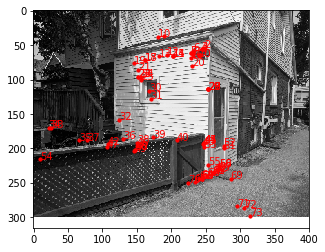

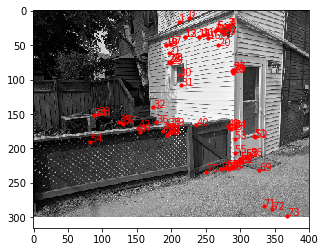

RANSAC number of inlers: 74
Total time: 13.506658792495728


In [40]:
start = time.time()
kwargs = {
    'sift':{'N':2,'s':5,'max_sup_window':(3,3)},
    'fk':{'block_size':16},
    'RANSAC':{'RANSAC_th':5,'RANSAC_p':0.1}
        }
MM = Match(im1='img/house/house0.jpg',
           im2='img/house/house8.jpg',
           kwargs=kwargs)

end = time.time()
print('Total time: {}'.format(end-start))

In [ ]:
start = time.time()

kwargs = {
    'sift':{'N':2,'s':5,'max_sup_window':(3,3)},
    'fk':{'block_size':16},
    'RANSAC':{'RANSAC_th':5,'RANSAC_p':0.3}
        }
MM = Match(im1='img/house/house8.jpg',
           im2='img/house/house23.jpg',
           kwargs=kwargs)

end = time.time()
print('Total time: {}'.format(end-start))

In [ ]:
start = time.time()

kwargs = {
    'sift':{'N':2,'s':5,'max_sup_window':(3,3)},
    'fk':{'block_size':16},
    'RANSAC':{'RANSAC_th':5,'RANSAC_p':0.3}
        }
MM = Match(im1='img/house/house23.jpg',
           im2='img/house/house22.jpg',
           kwargs=kwargs)

end = time.time()
print('Total time: {}'.format(end-start))

Ransac affine/homography best matches:


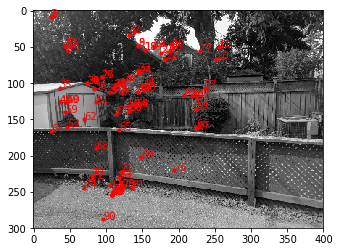

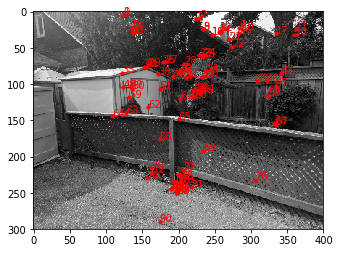

RANSAC number of inlers: 91
Total time: 14.874602317810059


In [43]:
start = time.time()

kwargs = {
    'sift':{'N':2,'s':5},
    'fk':{'block_size':16},
    'RANSAC':{'RANSAC_th':5,'RANSAC_p':0.1}
        }
MM = Match(im1='img/house/house18.jpg',
           im2='img/house/house16.jpg',
           kwargs=kwargs)

end = time.time()
print('Total time: {}'.format(end-start))

Ransac affine/homography best matches:


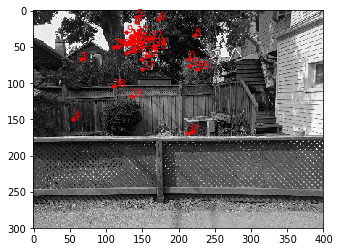

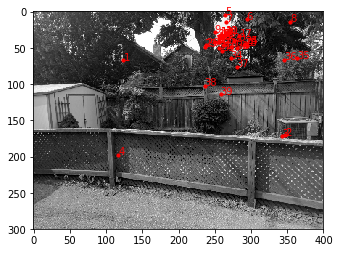

RANSAC number of inlers: 40
Total time: 9.088383674621582


In [44]:
start = time.time()

kwargs = {
    'sift':{'N':2,'s':5},
    'fk':{'block_size':16},
    'RANSAC':{'RANSAC_th':5,'RANSAC_p':0.3}
        }
MM = Match(im1='img/house/house22.jpg',
           im2='img/house/house18.jpg',
           kwargs=kwargs)

end = time.time()
print('Total time: {}'.format(end-start))

Ransac affine/homography best matches:


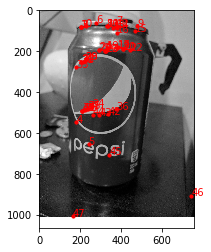

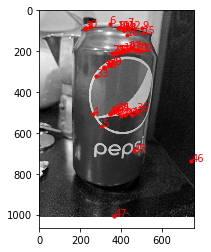

RANSAC number of inlers: 48
Total time: 29.292609453201294


In [45]:
start = time.time()

kwargs = {
    'sift':{'N':2,'s':5,'peak_th':0.01,'edge_th':10,'max_sup_window':(3,3)},
    'fk':{'block_size':16,'cell_size':4,'crt':0.5},
    'RANSAC':{'RANSAC_th':10,'RANSAC_p':0.1}
        }
MM = Match(im1='img/pepsi1.jpg',
           im2='img/pepsi2.jpg',
           kwargs=kwargs,Red=2)

end = time.time()
print('Total time: {}'.format(end-start))

Ransac affine/homography best matches:


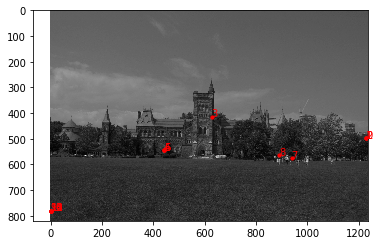

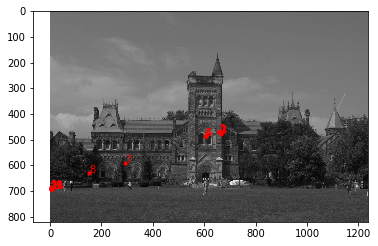

RANSAC number of inlers: 16
Total time: 76.62440133094788


In [55]:
start = time.time()

kwargs = {
    'sift':{'N':2,'s':5,'Red':1,'peak_th':0.01,'edge_th':10,'max_sup_window':(3,3)},
    'fk':{'block_size':16,'cell_size':4,'crt':0.8},
    'RANSAC':{'RANSAC_th':5,'RANSAC_p':0.1}
        }
MM = Match(im1='img/uoft4.jpg',
           im2='img/uoft6.jpg',
           kwargs=kwargs)

end = time.time()
print('Total time: {}'.format(end-start))

In [53]:
start = time.time()

kwargs = {
    'sift':{'N':2,'s':5,'peak_th':0.001,'edge_th':10,'max_sup_window':(3,3)},
    'fk':{'block_size':16,'cell_size':4,'crt':0.8},
    'RANSAC':{'RANSAC_th':10,'RANSAC_p':0.1}
        }

MM = Match(im1='img/book_temp.jpg',
           im2='img/book_match.jpg',
           kwargs=kwargs,
          homog_match=False)

end = time.time()
print('Total time: {}'.format(end-start))

Total time: 12.649375438690186


## General summary:
Planar/Distinctive objects: 
Scale Invariant interest points, SIFT descriptor, matching with nn + affine/homography

Panorama Stiching:
Scale Invariant interest points, SIFT descriptor, matching with nn + homography